This notebook is trying to illustrate the idea behind [t-SNE](https://lvdmaaten.github.io/tsne/) that **it tries to preserve local structure only while ignoring global structure when compared to other dimensionality reduction methods** with Swiss roll dataset as an example. See my comment in the notebook.

In [2]:
import os
import re
import datetime
import tempfile

import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 250)
# Don't cut off long string
# http://stackoverflow.com/questions/26277757/pandas-to-html-truncates-string-contents
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
# matplotlib.style.use('ggplot') # creates unecessary margin
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
import matplotlib.patheffects as PathEffects

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

In [3]:
n_samples = 1500
noise = 0.05
X, color = make_swiss_roll(n_samples, noise, random_state=0)
# Make it thinner
X[:, 1] *= .2

In [4]:
y = np.zeros(X.shape[0])

In [5]:
y[X[:,0]>0] = 1

In [6]:
y.shape

(1500,)

Assign labels to each point with [AgglomerativeClustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)

In [7]:
%time ward = AgglomerativeClustering(n_clusters=12, linkage='ward').fit(X)
label = ward.labels_

CPU times: user 1.23 s, sys: 7.94 ms, total: 1.24 s
Wall time: 1.24 s


In [8]:
label

array([ 1,  0,  1, ...,  3, 10,  8])

In [9]:
df_X = pd.DataFrame(X)
df_X['label'] = ward.labels_

In [10]:
df_X_sorted = df_X.sort_values([0, 1, 2]).reset_index()

In [11]:
df_X_sorted.head(2)

,index,0,1,2,label
0,1476,-9.571440,1.985690,-1.346911,5
1,694,-9.543589,2.733113,-2.134111,5


In [12]:
ref_idx = 85
ref_point = df_X_sorted[df_X_sorted['index'] == ref_idx]
ref_point

,index,0,1,2,label
855,85,4.301379,2.460615,5.857744,8


In [13]:
_df = df_X_sorted.ix[ref_point.index[0]:]
_df[[0,1,2]].values.argmax(axis=0)

array([644, 438,   1])

In [14]:
sorted_labels = sorted(np.unique(label))
colors = np.array(sns.color_palette("hls", len(sorted_labels)))

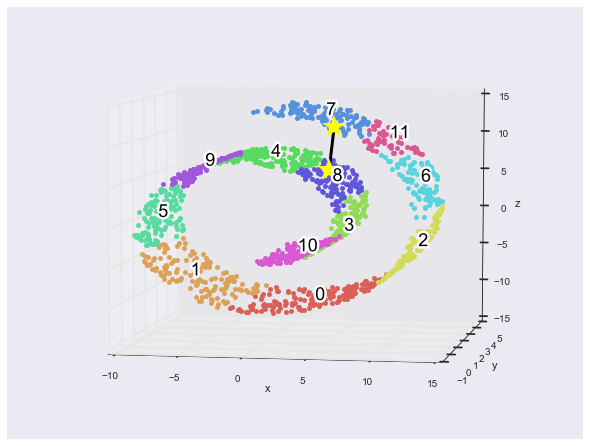

In [15]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
# for l in np.unique(label):
for k, lb in enumerate(sorted_labels):
    ax.plot3D(X[label == lb, 0], X[label == lb, 1], X[label == lb, 2], 'o', markersize=5, c=colors[k])
    xtext, ytext, ztext = np.median(X[label==lb,:], axis=0)
    txt = ax.text(xtext, ytext, ztext, str(k), fontsize=18, color='black')
    txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])

# for yi in [0, 1]:
#     ax.plot3D(X[y==yi, 0], X[y==yi, 1], X[y==yi, 2], 'o', markersize=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

p1, p2 = X[85], X[454]
ax.plot3D(*list(zip(p1, p2)), lw=3, c='black')
ax.plot3D(*list(zip(p1, p2)), '*', c='yellow', markersize=25, lw=3)
# fig.tight_layout()

Higlight two points with yellow stars to track how their distance changes during the dimensionality reduction process

# Start dimensionality reduction with different algorithms

#### PCA

In [16]:
X_pca = PCA(n_components=2).fit_transform(X)
df_X_pca = pd.DataFrame(X_pca)
df_X_pca['label'] = df_X.label

#### SVD

In [17]:
X_svd = TruncatedSVD(n_components=2).fit_transform(X)
df_X_svd = pd.DataFrame(X_svd)
df_X_svd['label'] = df_X.label

#### MDS

In [18]:
random_state = np.random.randint(0, 1e6)
# random_state = 477450
print('random_state: {0}'.format(random_state))
%time X_mds = MDS(n_components=2, random_state=random_state).fit_transform(X)
df_mds = pd.DataFrame(X_mds)
df_mds['label'] = df_X.label

random_state: 632975
CPU times: user 46.6 s, sys: 2.95 s, total: 49.5 s
Wall time: 12.8 s


t-SNE will be run three times with differnt learning rate to show how it affects the final outcome

#### t-SNE1

In [19]:
random_seed = np.random.randint(0, 1e6)
random_seed = 893489
print('random_seed: {0}'.format(random_seed))
lr1 = 50
%time X_tsne1 = TSNE(n_components=2, perplexity=50, learning_rate=lr1, random_state=random_seed).fit_transform(X)
df_tsne = pd.DataFrame(X_tsne1)
df_tsne['label'] = df_X.label

random_seed: 893489
CPU times: user 17.3 s, sys: 1.26 s, total: 18.6 s
Wall time: 17.5 s


#### t-SNE2

In [20]:
random_seed = np.random.randint(0, 1e6)
random_seed = 267595
print('random_seed: {0}'.format(random_seed))
lr2= 500
%time X_tsne2 = TSNE(n_components=2, perplexity=50, learning_rate=lr2, random_state=random_seed).fit_transform(X)
df_tsne = pd.DataFrame(X_tsne2)
df_tsne['label'] = df_X.label

random_seed: 267595
CPU times: user 16.6 s, sys: 1.26 s, total: 17.8 s
Wall time: 17 s


#### t-SNE3

In [21]:
random_seed = np.random.randint(0, 1e6)
random_seed = 320571
print('random_seed: {0}'.format(random_seed))
lr3 = 1000
%time X_tsne3 = TSNE(n_components=2, perplexity=50, learning_rate=lr3, random_state=random_seed).fit_transform(X)
df_tsne = pd.DataFrame(X_tsne3)
df_tsne['label'] = df_X.label

random_seed: 320571
CPU times: user 7.26 s, sys: 509 ms, total: 7.77 s
Wall time: 6.82 s


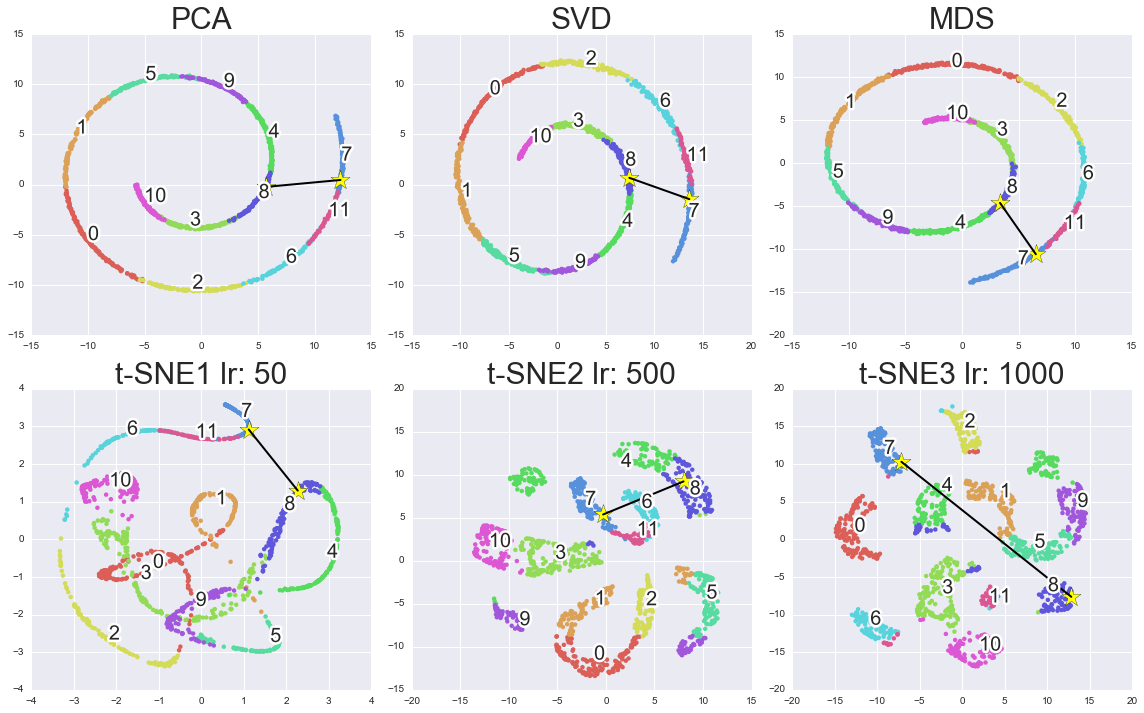

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for j, (method, lr, X2d) in enumerate(zip(
    ['PCA', 'SVD', 'MDS', 't-SNE1', 't-SNE2', 't-SNE3'],
    ['', '', '', lr1, lr2, lr3],
    [X_pca, X_svd, X_mds, X_tsne1, X_tsne2, X_tsne3])):
    ax = axes[j]
    for k, lb in enumerate(sorted_labels):
        ax.scatter(X2d[label==lb, 0], X2d[label==lb, 1], marker='o', edgecolors='None', c=colors[k])
        xtext, ytext = np.median(X2d[label==lb,:], axis=0)
        txt = ax.text(xtext, ytext, str(k), fontsize=20)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        
    p1, p2 = X2d[85], X2d[454]
    ax.plot(*list(zip(p1, p2)), lw=2, color='black')
    ax.scatter(*list(zip(p1, p2)), marker='*', s=400, c='yellow')
    
    title = method + ' lr: ' + str(lr) if j >= 3 else method
    ax.set_title(title, fontsize=30)

# ax.scatter(*list(zip(p1, p2)), '*', c='yellow', markersize=30, lw=3)
fig.tight_layout()

1. As can be seen from the above graph that with t-SNE, the global structure, represented by the distance between two points highlighted with yellow stars are fully distorted while neighbouring points stay close.

1. It also shows that different learning rates will have dramatic effect on the shape of t-SNE outcome. A learning rate of 50 is usually considered too small. 

1. The shape t-SNE outcome kind of resembles that of the original dataset, but not reliable. E.g. it is highly sensitive to learning rate and possibly other parameters, too (perplexity, random state)

## Below is used to illustrate the t-SNE only tries preserves local structure, the inter-clusters distance is not meaningful anymore

In [48]:
random_seed = np.random.randint(0, 1e6)
random_seed = 573581 # very far
print('random_seed: {0}'.format(random_seed))
lr4 = 1000
%time X_tsne4 = TSNE(n_components=2, perplexity=50, learning_rate=lr4, random_state=random_seed).fit_transform(X)
df_tsne = pd.DataFrame(X_tsne3)
df_tsne['label'] = df_X.label

random_seed: 320571
CPU times: user 7.13 s, sys: 497 ms, total: 7.62 s
Wall time: 6.79 s


In [49]:
random_seed = np.random.randint(0, 1e6)
random_seed = 730449
print('random_seed: {0}'.format(random_seed))
lr5 = 1000
%time X_tsne5 = TSNE(n_components=2, perplexity=50, learning_rate=lr5, random_state=random_seed).fit_transform(X)
df_tsne = pd.DataFrame(X_tsne5)
df_tsne['label'] = df_X.label

random_seed: 730449
CPU times: user 7.31 s, sys: 560 ms, total: 7.87 s
Wall time: 6.84 s


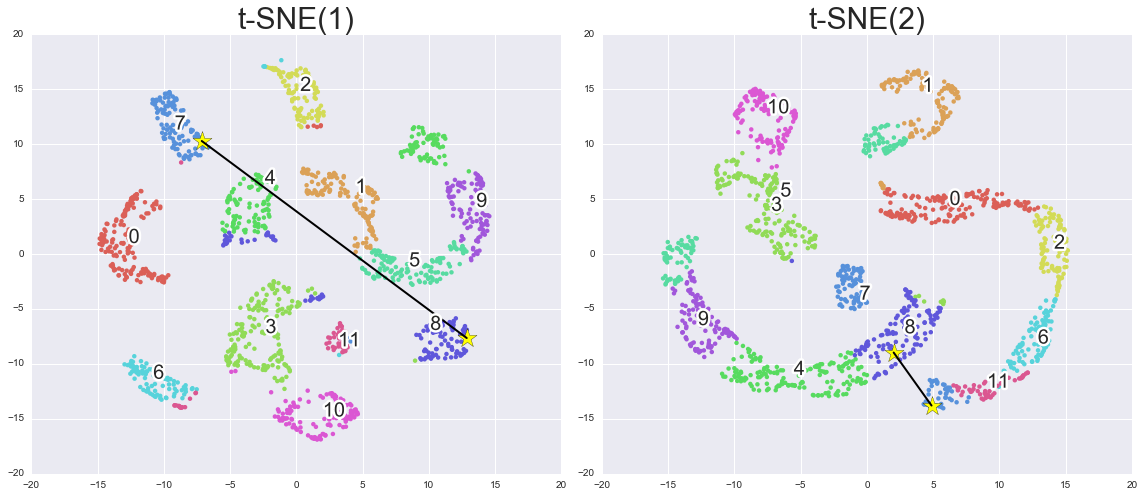

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
axes = axes.ravel()

for j, (method, lr, X2d) in enumerate(zip(
    ['t-SNE(1)', 't-SNE(2)'],
    [lr3, lr4],
    [X_tsne4, X_tsne5])):
    ax = axes[j]
    for k, lb in enumerate(sorted_labels):
        ax.scatter(X2d[label==lb, 0], X2d[label==lb, 1], marker='o', edgecolors='None', c=colors[k])
        xtext, ytext = np.median(X2d[label==lb,:], axis=0)
        txt = ax.text(xtext, ytext, str(k), fontsize=20)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        
    p1, p2 = X2d[85], X2d[454]
    ax.plot(*list(zip(p1, p2)), lw=2, color='black')
    ax.scatter(*list(zip(p1, p2)), marker='*', s=400, c='yellow')
    
    title = method + ' lr: ' + str(lr) if j >= 3 else method
    ax.set_title(title, fontsize=30)

# ax.scatter(*list(zip(p1, p2)), '*', c='yellow', markersize=30, lw=3)
fig.tight_layout()